In [1]:
# Qiskit and maths
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Initialize, QFT
from qiskit_aer.primitives import Sampler

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Finance information
import yfinance as yf
import pandas as pd

# Extras :)
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [15]:
def train_qgan(
    quantum_gen_fn, generator_params, discriminator, dataloader,
    num_epochs=100, disc_lr=5e-5, g_lr=2e-4, latent_dim=8, device='cpu',
    generator_update_fn=None, n_qubits=None, k_layers=None, bounds=None, mu=None, sigma=None
):

    gen_losses = []
    disc_losses = []
    kl_divs = []
    discriminator.to(device)
    epsilon = 1e-8

    dis_opt = optim.Adam(discriminator.parameters(), lr=disc_lr, amsgrad=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        for real_data_batch in tqdm(dataloader, desc="Training step"):
            real_data = real_data_batch[0].to(device)
            batch_size = real_data.size(0)

            # === Train Discriminator ===
            dis_opt.zero_grad()

            # Real data
            real_preds = discriminator(real_data)
            # === Label smoothing ===
            real_labels = torch.full_like(real_preds, 0.9)  # Smooth label for real
            fake_labels = torch.full_like(fake_preds, 0.1)  # Smooth label for fake
            
            # === Binary cross-entropy with smoothed targets
            real_loss = F.binary_cross_entropy(real_preds, real_labels)
            fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)
            
            disc_loss = real_loss + fake_loss

            disc_loss = -torch.mean(real_loss + fake_loss)
            disc_loss.backward()
            dis_opt.step()

            # === Train Generator ===
            # Do NOT use .backward() — assume manual gradient update
            noise = torch.randn(batch_size, latent_dim)
            fake_data = quantum_gen_fn(noise, generator_params).to(device)
            fake_preds = discriminator(fake_data)

            gen_loss = -torch.mean(torch.log(fake_preds + epsilon))

            generator_update_fn(
                theta=generator_params, noise_batch=noise, discriminator=discriminator
            )

        
        # === Logging losses ===
        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())
        
        # === KL-Divergence between real & generated data ===
        noise = torch.randn(1000, latent_dim)
        fake_samples = quantum_gen_fn(noise, generator_params).detach().cpu()
        
        real_flat = real_data[:len(fake_samples)].mean(dim=0)
        fake_flat = fake_samples.mean(dim=0)
        
        bins = real_flat.shape[0]  # = 64 for 6 qubits
        
        eps = 1e-8  # avoid log(0)
        
        # Use flat distributions directly (no need for torch.histc)
        fake_prob = fake_flat / fake_flat.sum() + eps
        real_prob = real_flat / real_flat.sum() + eps
        
        
        kl = F.kl_div(generated.log(), real_target, reduction='batchmean')
        kl_divs.append(kl.item())
        
        # === Combined LIVE PLOTS ===
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        
        # 1. Losses
        axs[0].plot(gen_losses, label="Generator")
        axs[0].plot(disc_losses, label="Discriminator")
        axs[0].set_title("Losses")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[0].grid(True)
        
        # 2. KL Divergence
        axs[1].plot(kl_divs, label="KL(G || R)", color='purple')
        axs[1].set_title("KL Divergence")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("KL")
        axs[1].legend()
        axs[1].grid(True)
        
        # 3. Histogram comparison
        # Convert probabilities into sampled indices
        real_indices = np.random.choice(np.arange(bins), p=real_flat.numpy(), size=1000)
        fake_indices = np.random.choice(np.arange(bins), p=fake_flat.numpy() / fake_flat.numpy().sum(), size=1000)
        
        # Plot sampled histograms
        axs[2].hist(real_indices, bins=bins, alpha=0.5, label="Real", density=True)
        axs[2].hist(fake_indices, bins=bins, alpha=0.5, label="Generated", density=True)
        axs[2].set_title("Distribution Comparison")
        axs[2].set_xlabel("Value")
        axs[2].set_ylabel("Probability")
        axs[2].legend()
        axs[2].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # === Epoch info printout ===
        print(f"Epoch [{epoch+1}/{num_epochs}]  D_loss: {disc_loss.item():.4f}  G_loss: {gen_loss.item():.4f}  KL: {kl.item():.4f}")

In [9]:
def custom_normal_encoding(n, mu=0, sigma=1, bounds=(-np.pi, np.pi)):
    dim = 2 ** n
    x = np.linspace(bounds[0], bounds[1], dim)

    # Evaluate normal distribution (PDF)
    probs = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    probs /= np.sum(probs)  # Normalize

    # Convert to amplitudes
    amps = np.sqrt(probs)

    # Create quantum circuit
    qc = QuantumCircuit(n)
    init = Initialize(amps)
    qc.append(init, range(n))

    return qc

In [10]:
def quantum_gen_fn(noise_batch, theta, n, k, bounds, mu, sigma):
    sampler = Sampler()
    circuits = []

    for noise_vec in noise_batch:
        theta_np = theta.detach().cpu().numpy()
        noise_np = noise_vec.detach().cpu().numpy()

        # Build quantum circuit
        qc = QuantumCircuit(n)
        qc.h(range(n)) # Random normal distribution

        for j in range(k):
            for i in range(n):
                angle = theta_np[i, j] + 0.2 * noise_np[i]
                qc.ry(angle, i)

            if j != k - 1:
                for i in range(n - 1):
                    qc.cz(i, i + 1)
                qc.cz(n - 1, 0)

        qc.measure_all()
        circuits.append(qc)

    results = sampler.run(circuits).result()

    # Extract probabilities
    batch_outputs = []
    for i, result in enumerate(results.quasi_dists):
        probs = np.zeros(2**n_qubits)
        for bitstring, prob in result.items():
            index = int(bitstring)
            probs[index] = prob
        batch_outputs.append(probs)

    return torch.tensor(batch_outputs, dtype=torch.float32)

In [11]:
def parameter_shift_update(theta, noise_batch, discriminator, lr, n_qubits, k_layers, bounds, mu, sigma):
    n, k = theta.shape
    batch_size = noise_batch.size(0)
    shift = np.pi / 2

    grad = torch.zeros_like(theta)

    with torch.no_grad():
        for i in range(n):
            for j in range(k):
                # Shifted parameter sets
                theta_plus = theta.clone()
                theta_plus[i, j] += shift
                theta_minus = theta.clone()
                theta_minus[i, j] -= shift

                # Generate samples using shifted parameters
                g_plus = quantum_gen_fn(noise_batch, theta_plus, n_qubits, k_layers, bounds, mu, sigma)
                g_minus = quantum_gen_fn(noise_batch, theta_minus, n_qubits, k_layers, bounds, mu, sigma)

                # Evaluate discriminator outputs
                D_plus = discriminator(g_plus)
                D_minus = discriminator(g_minus)

                # Compute gradient: average over batch
                log_d_plus = torch.log(D_plus + 1e-8)
                log_d_minus = torch.log(D_minus + 1e-8)
                grad[i, j] = -torch.mean((log_d_plus - log_d_minus) / 2)

        # Gradient descent step
        theta -= lr * grad

# Load the data

In [12]:
# Create QFT states
n_qubits = 6

# Initialize basis state |x⟩ = |5⟩ for example (can be any 0–7)
x = 5
qc = QuantumCircuit(n_qubits)
qc.initialize([0]*x + [1] + [0]*(2**n_qubits - x - 1), range(n_qubits))

# Apply QFT
qft = QFT(num_qubits=n_qubits, do_swaps=False).decompose()
qc.append(qft, range(n_qubits))

# Simulate
sv = Statevector.from_instruction(qc)

# Measurement probabilities
probs = sv.probabilities_dict()

# Turn into vector over 2^n bins
target_distribution = np.zeros(2**n_qubits)
for bitstring, prob in probs.items():
    idx = int(bitstring, 2)
    target_distribution[idx] = prob

# Convert to torch tensor
real_data = torch.tensor(target_distribution, dtype=torch.float32)

# Train the Data

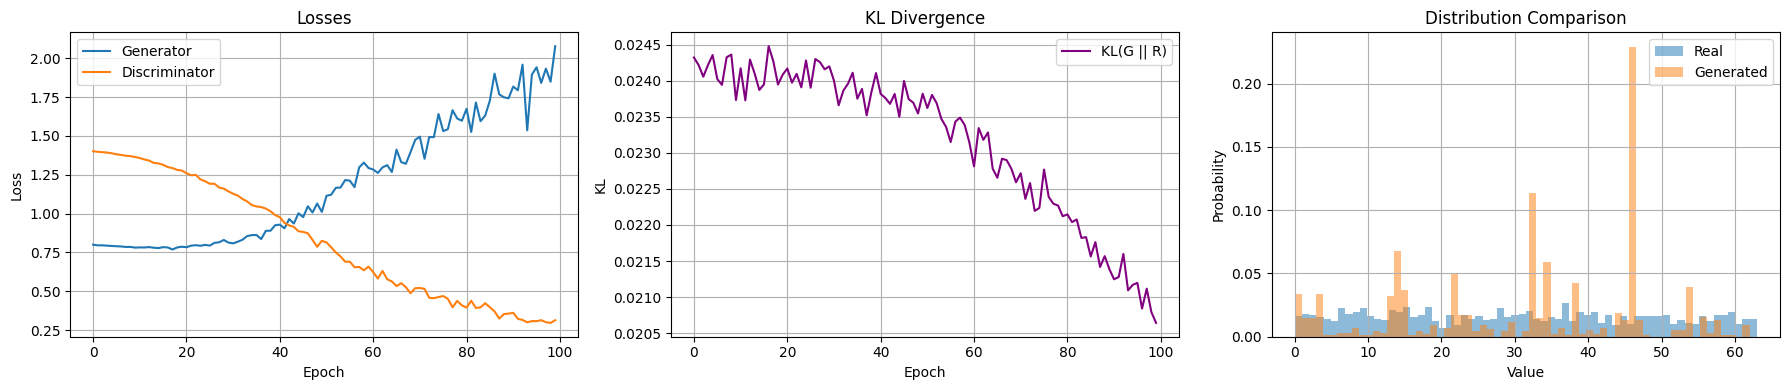

Epoch [100/100]  D_loss: 0.3136  G_loss: 2.0777  KL: 0.0206


In [13]:
# Initial Parameters
mu = 0.5
sigma = 1
bounds = [-1.5, 1.5]
n = 6
k = 3
theta = nn.Parameter(torch.randn(n, k, dtype=torch.float32, requires_grad=True))

# Sample indices based on QFT probabilities
num_samples = 1000
real_data = torch.tensor([target_distribution] * num_samples, dtype=torch.float32)

# Repeat the full distribution for each training sample
num_samples = 1000  # number of training rows, each showing the same target
samples = torch.tensor([target_distribution] * num_samples, dtype=torch.float32)

# Wrap in DataLoader
train_load = DataLoader(TensorDataset(samples), batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Linear(64, 20),
    nn.LeakyReLU(0.01),
    nn.Linear(20, 1),
    nn.Sigmoid()
)

gen_update_fn = partial(
    parameter_shift_update,
    lr=2e-4, n_qubits=n, k_layers=k, bounds=bounds, mu=mu, sigma=sigma
)

train_qgan(
    quantum_gen_fn=lambda noise, theta: quantum_gen_fn(
        noise, theta, n=n, k=k, bounds=bounds, mu=mu, sigma=sigma
    ),
    generator_params=theta,
    discriminator=model,
    dataloader=train_load,
    g_lr=2e-4,
    generator_update_fn=gen_update_fn
)